# Canadian house price analysis
## Sections
1. [Motivation](#motivation)
2. [Data importation and cleaning](#data-importation-and-cleaning)
3. [Data analysis](#data-analysis)
    1. [Overview of Canada and the provinces from 1990](#overview-of-canada-and-the-provinces-from-1990)
    2. [Demand side analysis](#demand-side-analysis)
    3. [Supply side analysis](#supply-side-analysis)

## Motivation
Recent inflation number and house price records have constantly make news. This report is inspired by [the analysis carried out by Bank of Canada in 2015](https://www.bankofcanada.ca/2015/08/long-term-evolution-house-prices/) using more up-to-date data from Statistics Canada.

## Data importation and cleaning

In [79]:
import pandas as pd
import matplotlib.pyplot as plt
import os
import seaborn as sns
sns.set_theme()
pwd = os.getcwd()

### Importing data

#### New housing price index data (monthly)

In [80]:
#Load new housing price index data
df = pd.read_csv(pwd+'\\data\\raw\\housing\\18100205.csv',header = 0, parse_dates=['REF_DATE'])
df = df[['REF_DATE','GEO','New housing price indexes','VALUE']]
#Get table of metadata of new housing price index
df_md = pd.read_csv(pwd+'\\data\\raw\\housing\\18100205_MetaData.csv',header = 0, skiprows =7,nrows = 43)


#### Income data (annual)

In [81]:
#Load income data in dollars
dfIncome = pd.read_csv(pwd+'\\data\\raw\\income\\11100239.csv',header = 0,parse_dates=['REF_DATE'])
#Select the data of all age group, both sexes, total median income
dfIncome = dfIncome[(dfIncome['Age group'] == '16 years and over')\
    &(dfIncome['Sex'] == 'Both sexes')\
        &(dfIncome['Income source'] == 'Total income')\
            &(dfIncome['Statistics'] == 'Median income (excluding zeros)')]\
                [['REF_DATE','GEO','VALUE']]


#### Population data (annual)

In [82]:
#Load population data
dfPop = pd.read_csv(pwd+'\\data\\raw\\population\\17100005.csv',header = 0,parse_dates=['REF_DATE'])
#Select the data of all age group, both sexes, and only neccessary columns
dfPop = dfPop[(dfPop['Age group'].str.contains('All'))\
    &(dfPop['Sex']=='Both sexes')\
        ][['REF_DATE','GEO','VALUE']]

D:\7.Programs\Anaconda\lib\site-packages\IPython\core\interactiveshell.py:3444: DtypeWarning: Columns (12,14) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


#### Industrial product price index (IPPI) data (monthly)

In [83]:
#Load industrial product price index data
dfIndu = pd.read_csv(pwd+'\\data\\raw\\IPPI\\18100265.csv',header = 0,parse_dates=['REF_DATE'])
#Construction product code from metadata:
productCodes = ['[P41]','[P31]','[P63]']
#Select the data of all age group, both sexes, and only neccessary columns
dfIndu = dfIndu[(dfIndu['North American Product Classification System (NAPCS)']\
    .str.contains('\[P(41|31|63)\]',regex=True))]\
        [['REF_DATE','GEO','VALUE','North American Product Classification System (NAPCS)']]
dfIndu = dfIndu.groupby(['REF_DATE']).agg({'VALUE':'mean'}).reset_index()

C:\Users\OS\AppData\Local\Temp/ipykernel_9780/1004861230.py:6: UserWarning: This pattern has match groups. To actually get the groups, use str.extract.
  dfIndu = dfIndu[(dfIndu['North American Product Classification System (NAPCS)']\


### Data cleaning 
Main goal: separate data geographically

#### Housing data

In [84]:
#Get total new house price index (land + house)
df = df[df['New housing price indexes'].str.contains('Total')]
#Get data for all Canada
df_Can = df[(df.GEO == "Canada")]
#Condition to get total houe value: df["New housing price indexes"].str.contains('Total')
#Get provinces name from metadata file
unique_province_id = df_md['Parent Member ID'].unique()
provinces_names = df_md[(df_md['Member ID'].isin(unique_province_id)) & (df_md['Dimension ID']==1) \
    & ~(df_md['Member ID'].isin([1,2,28]))]['Member Name']
#Get a dictionary province_df to store each province data where keys are name of provinces, values are dictionary
province_df = {}
for name in provinces_names:
    province_df[name] = df[df.GEO == name]

#### Income data

In [85]:
dfIncome_CAN = dfIncome[dfIncome['GEO']=='Canada']
province_df_Income = {}
for name in provinces_names:
    province_df_Income[name] = dfIncome[dfIncome.GEO == name]

#### Population

In [86]:
dfPop_CAN = dfPop[dfPop['GEO']=='Canada']
province_df_Pop = {}
for name in provinces_names:
    province_df_Pop[name] = dfPop[dfPop.GEO == name]

#### IPPI data
The IPPI data does not require additional processing since it does not separate price index for each province. 

## Data analysis

### Overview of Canada and the provinces from 1990
**Findings**
- From Fig 1 we can see that from 1990, new house price index (NHPI) in general for Canada remained relatively stable during 1990-1999, grew linearly during 2010-2018, experienced exponential growth during 2000-2008 and 2019-2021. Suprisingly, Canada's NHPI is only minimally affected by financial crisis in 2008.

- From Fig 2, the order of the NHPI among the top 5 provinces remained consistent during 1990-2005 period where the order follows as BC, QC, ON (close second), AB, SK. During 2006-2019, it can be observed that new house prices in the Prairies increase dramatically, and the top 5 provinces remain similar level of NHPI. However, from 2019, we can observe a bifurcation of NHPI among the 5 into 2 groups: ON, BC, QC vs AB and SK.


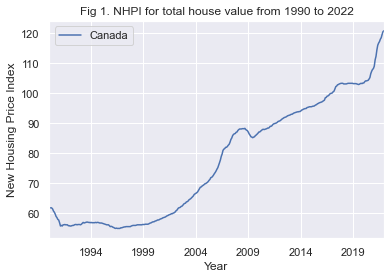

In [87]:
#Extract total house value data of entire Canada
after1990_CAN = df_Can[df_Can['REF_DATE'] >= '01-1990']
lay1 = after1990_CAN.plot(x = 'REF_DATE',y = 'VALUE')
plt.xlabel('Year')
plt.ylabel('New Housing Price Index')
plt.title('Fig 1. NHPI for total house value from 1990 to 2022')
plt.legend(['Canada'])

Text(0.5, 1.0, 'Fig 2. NHPI for total house value of 5 economically largest province from 1990 to 2022')

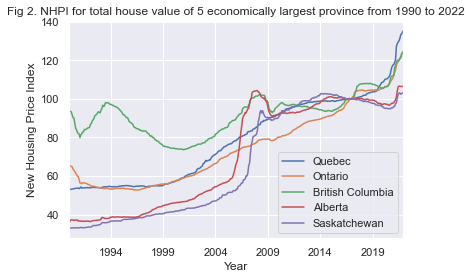

In [88]:
#Comparing top 5 highest GDP provinces to the Canada
quebec = province_df['Quebec']
quebec = quebec[(quebec['New housing price indexes'].str.contains('Total')) &(quebec['REF_DATE']>='01-1990')]
layqc = quebec.plot(x = 'REF_DATE',y = 'VALUE')

ontario = province_df['Ontario']
ontario = ontario[(ontario['New housing price indexes'].str.contains('Total')) &(ontario['REF_DATE']>='01-1990')]
layon = ontario.plot(x = 'REF_DATE',y = 'VALUE', ax = layqc)

bc = province_df['British Columbia']
bc = bc[(bc['New housing price indexes'].str.contains('Total')) &(bc['REF_DATE']>='01-1990')]
laybc = bc.plot(x = 'REF_DATE',y = 'VALUE', ax = layon)

ab = province_df['Alberta']
ab = ab[(ab['New housing price indexes'].str.contains('Total')) &(ab['REF_DATE']>='01-1990')]
layab = ab.plot(x = 'REF_DATE',y = 'VALUE', ax = laybc)

sk = province_df['Saskatchewan']
sk = sk[(sk['New housing price indexes'].str.contains('Total')) &(sk['REF_DATE']>='01-1990')]
laysk = sk.plot(x = 'REF_DATE',y = 'VALUE', ax = layab)

plt.legend(['Quebec','Ontario','British Columbia', 'Alberta','Saskatchewan'])
plt.xlabel('Year')
plt.ylabel('New Housing Price Index')
plt.title('Fig 2. NHPI for total house value of 5 economically largest province from 1990 to 2022')


### Demand side analysis
As pointed out by the Bank of Canada report on pg. 3, there are potentially 4 major demand side, which are:
- macroeconomics: incomes and long-term interest rate
- demographic: population increase, age demographic change
- credit condition: more efficient funding of mortgage credit
- other factors: i.e. international investment
Among the listed factors, this work will only concern with incomes change and population increase due to easy access to data.

#### NHPI vs income
**Findings**
- From Fig. 3, for Canada, it seems that median income correlates with NHPI. However, we can see that the NHPI increases at a quicker rate than median income. For instance, during 2000-2020, while NHPI increases more than 166%, median total income for an average canadian only increases less than 133%.

- In general, the provinces NHPI and total median income follow the same behavior as Canada in general: median income does not increase as quickly as NHPI. For instance from 2000 to 2020, the rate of increases of NHPI vs median income for each provinces are:
    - Ontario: 190% vs 114%
    - Quebec: 198% vs 134%
    - BC: 147% vs 130%
    - Alberta: 211% vs 124%
    - Saskatchewan: 237% vs 144%

- It is also very interesting to note that for all except SK, we can see a dip in median income from the 90s that bottoms around 2000. However, NHPI curves only follow the same behavior in ON, which is not severe, and BC, which is quite severe.

- Additionally, QC's NPHI has never really decrease but only plateaued.

- Among the provinces only BC and AB experience a drop in NHPI during economic recession of 2008, whereas the NHPI of the other provinces do not seem to correlate with the event.

##### Canada

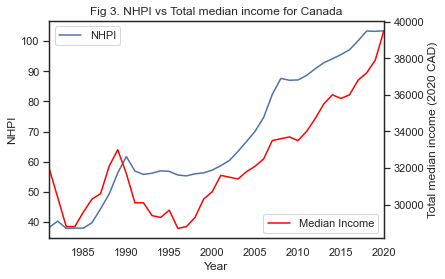

In [89]:
#Perform a query on 2 tables: NHPI and income
NHPIvsIncome_CAN = df[df.GEO =='Canada'].merge(dfIncome_CAN,on='REF_DATE',suffixes=("_NHPI","_Income"))\
    .drop(columns=['GEO_NHPI','GEO_Income','New housing price indexes'])
#Plot a 2 y-axes line plot
sns.set_theme(style="white", palette=None)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
NHPIvsIncome_CAN.plot(x='REF_DATE',y='VALUE_NHPI',ax=ax1)
ax1.set_ylabel('NHPI')
ax1.set_xlabel('Year')
ax1.legend(['NHPI'])
NHPIvsIncome_CAN.plot(x='REF_DATE',y='VALUE_Income',color="red",ax=ax2)
ax2.set_ylabel('Total median income (2020 CAD)')
ax2.legend(['Median Income'], loc = 4)
ax1.set_title('Fig 3. NHPI vs Total median income for Canada')
plt.show()

##### Canadian 5 economically biggest province

1. Ontario

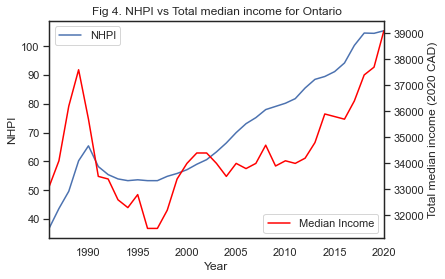

In [90]:
#Query for the NHPI and Median income of Ontario
temp1 = province_df['Ontario']
temp2 = province_df_Income['Ontario']

NHPIvsIncome_ON = temp1[~temp1.VALUE.isna()].merge(temp2,on='REF_DATE',suffixes=('_NHPI','_Income'))\
    .drop(columns=['GEO_NHPI','GEO_Income','New housing price indexes'])
#Plot a 2 y-axes line plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
NHPIvsIncome_ON.plot(x='REF_DATE',y='VALUE_NHPI',ax=ax1)
ax1.set_ylabel('NHPI')
ax1.set_xlabel('Year')
ax1.legend(['NHPI'])
NHPIvsIncome_ON.plot(x='REF_DATE',y='VALUE_Income',color="red",ax=ax2)
ax2.set_ylabel('Total median income (2020 CAD)')
ax2.legend(['Median Income'], loc = 4)
ax1.set_title('Fig 4. NHPI vs Total median income for Ontario')
plt.show()



2. Quebec

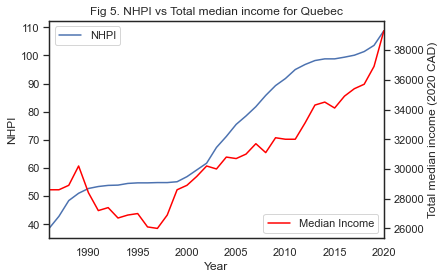

In [91]:
#Query for the NHPI and Median income of Quebec
temp1 = province_df['Quebec']
temp2 = province_df_Income['Quebec']

NHPIvsIncome_QC = temp1[~temp1.VALUE.isna()].merge(temp2,on='REF_DATE',suffixes=('_NHPI','_Income'))\
    .drop(columns=['GEO_NHPI','GEO_Income','New housing price indexes'])
#Plot a 2 y-axes line plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
NHPIvsIncome_QC.plot(x='REF_DATE',y='VALUE_NHPI',ax=ax1)
ax1.set_ylabel('NHPI')
ax1.set_xlabel('Year')
ax1.legend(['NHPI'])
NHPIvsIncome_QC.plot(x='REF_DATE',y='VALUE_Income',color="red",ax=ax2)
ax2.set_ylabel('Total median income (2020 CAD)')
ax2.legend(['Median Income'], loc = 4)
ax1.set_title('Fig 5. NHPI vs Total median income for Quebec')
plt.show()

3. British Columnbia

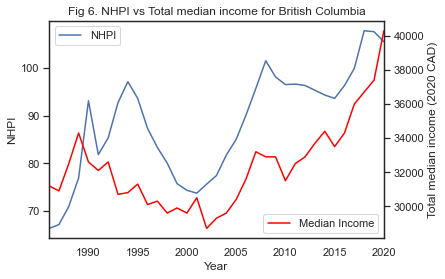

In [92]:
#Query for the NHPI and Median income of British Columbia
temp1 = province_df['British Columbia']
temp2 = province_df_Income['British Columbia']

NHPIvsIncome_BC = temp1[~temp1.VALUE.isna()].merge(temp2,on='REF_DATE',suffixes=('_NHPI','_Income'))\
    .drop(columns=['GEO_NHPI','GEO_Income','New housing price indexes'])
#Plot a 2 y-axes line plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
NHPIvsIncome_BC.plot(x='REF_DATE',y='VALUE_NHPI',ax=ax1)
ax1.set_ylabel('NHPI')
ax1.set_xlabel('Year')
ax1.legend(['NHPI'])
NHPIvsIncome_BC.plot(x='REF_DATE',y='VALUE_Income',color="red",ax=ax2)
ax2.set_ylabel('Total median income (2020 CAD)')
ax2.legend(['Median Income'], loc = 4)
ax1.set_title('Fig 6. NHPI vs Total median income for British Columbia')
plt.show()

4. Alberta

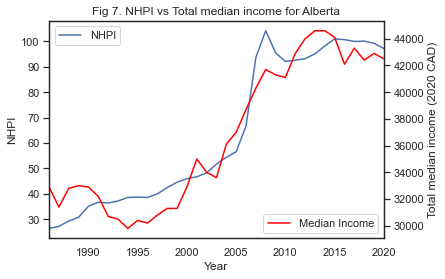

In [93]:
#Query for the NHPI and Median income of Alberta
temp1 = province_df['Alberta']
temp2 = province_df_Income['Alberta']

NHPIvsIncome_AB = temp1[~temp1.VALUE.isna()].merge(temp2,on='REF_DATE',suffixes=('_NHPI','_Income'))\
    .drop(columns=['GEO_NHPI','GEO_Income','New housing price indexes'])
#Plot a 2 y-axes line plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
NHPIvsIncome_AB.plot(x='REF_DATE',y='VALUE_NHPI',ax=ax1)
ax1.set_ylabel('NHPI')
ax1.set_xlabel('Year')
ax1.legend(['NHPI'])
NHPIvsIncome_AB.plot(x='REF_DATE',y='VALUE_Income',color="red",ax=ax2)
ax2.set_ylabel('Total median income (2020 CAD)')
ax2.legend(['Median Income'],loc =4 )
ax1.set_title('Fig 7. NHPI vs Total median income for Alberta')
plt.show()

5. Saskatchewan

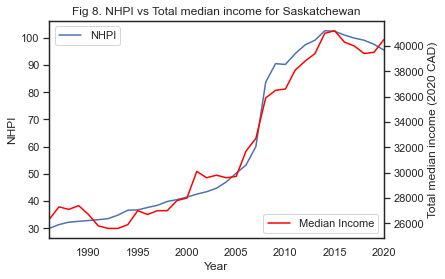

In [94]:
#Query for the NHPI and Median income of Saskatchewan
temp1 = province_df['Saskatchewan']
temp2 = province_df_Income['Saskatchewan']

NHPIvsIncome_SK = temp1[~temp1.VALUE.isna()].merge(temp2,on='REF_DATE',suffixes=('_NHPI','_Income'))\
    .drop(columns=['GEO_NHPI','GEO_Income','New housing price indexes'])
#Plot a 2 y-axes line plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
NHPIvsIncome_SK.plot(x='REF_DATE',y='VALUE_NHPI',ax=ax1)
ax1.set_ylabel('NHPI')
ax1.set_xlabel('Year')
ax1.legend(['NHPI'])
NHPIvsIncome_SK.plot(x='REF_DATE',y='VALUE_Income',color="red",ax=ax2)
ax2.set_ylabel('Total median income (2020 CAD)')
ax2.legend(['Median Income'], loc = 4)
ax1.set_title('Fig 8. NHPI vs Total median income for Saskatchewan')
plt.show()

#### NHPI vs population
**Findings**
- From Fig 9. it is very suprising to see how well the 2 curves of NHPI and population correlate.

- Among the provinces, the two fascinating cases are BC and SK:
    - For BC, in Fig 12, during 1995 and 2005, we can see the drop and the rebound of NHPI happens during the period of population growth rate slows down
    
    - For SK, in Fig 14, up to 2005, the population had been slowly decreasing. However, despite this fact, NHPI still grows linearly. More shockingly, after 2005, population experiences a sudden growth and almost immediately we can see the rate of increase of NHPI immediately speed up. It is very likely that the population increase is due to the introduction of a new immigration program and is not from inter-province migration, and these new immigrants to SK might have purchased homes which increase the demand thus increase the price of new homes. However, this is an speculative observation that requires further data-driven investigation to be proven correct.

##### Canada

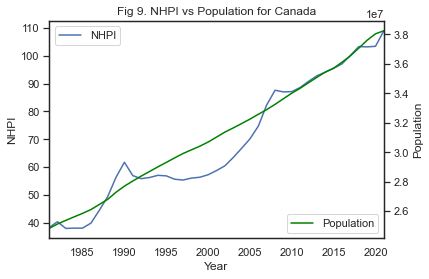

In [95]:
#Perform a query on 2 tables: NHPI and income
NHPIvsPop_CAN = df[df.GEO =='Canada'].merge(dfPop_CAN,on='REF_DATE',suffixes=("_NHPI","_Pop"))\
    .drop(columns=['GEO_NHPI','GEO_Pop','New housing price indexes'])
#Plot a 2 y-axes line plot
sns.set_theme(style="white", palette=None)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
NHPIvsPop_CAN.plot(x='REF_DATE',y='VALUE_NHPI',ax=ax1)
ax1.set_ylabel('NHPI')
ax1.set_xlabel('Year')
ax1.legend(['NHPI'])
NHPIvsPop_CAN.plot(x='REF_DATE',y='VALUE_Pop',color="green",ax=ax2)
ax2.set_ylabel('Population')
ax2.legend(['Population'],loc=4)
ax1.set_title('Fig 9. NHPI vs Population for Canada')
plt.show()

##### Top 5 economically biggest provinces

1. Ontario

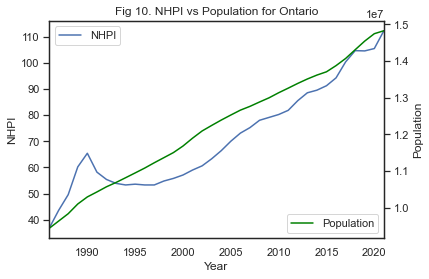

In [96]:
#Query for the NHPI and Population of Ontario
temp1 = province_df['Ontario']
temp2 = province_df_Pop['Ontario']
NHPIvsPop_ON = temp1[~temp1.VALUE.isna()].merge(temp2[~temp2.VALUE.isna()],on='REF_DATE',suffixes=('_NHPI','_Pop'))\
    .drop(columns=['GEO_NHPI','GEO_Pop','New housing price indexes'])

#Plot a 2 y-axes line plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
NHPIvsPop_ON.plot(x='REF_DATE',y='VALUE_NHPI',ax=ax1)
ax1.set_ylabel('NHPI')
ax1.set_xlabel('Year')
ax1.legend(['NHPI'])
NHPIvsPop_ON.plot(x='REF_DATE',y='VALUE_Pop',color="green",ax=ax2)
ax2.set_ylabel('Population')
ax2.legend(['Population'],loc = 4)
ax1.set_title('Fig 10. NHPI vs Population for Ontario')
plt.show()

2. Quebec

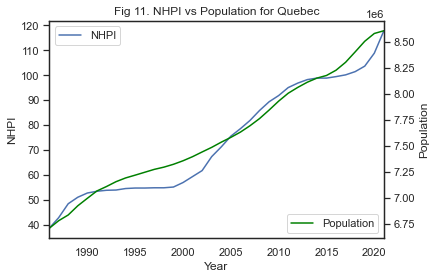

In [97]:
#Query for the NHPI and Population of Quebec
temp1 = province_df['Quebec']
temp2 = province_df_Pop['Quebec']
NHPIvsPop_QC = temp1[~temp1.VALUE.isna()].merge(temp2[~temp2.VALUE.isna()],on='REF_DATE',suffixes=('_NHPI','_Pop'))\
    .drop(columns=['GEO_NHPI','GEO_Pop','New housing price indexes'])

#Plot a 2 y-axes line plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
NHPIvsPop_QC.plot(x='REF_DATE',y='VALUE_NHPI',ax=ax1)
ax1.set_ylabel('NHPI')
ax1.set_xlabel('Year')
ax1.legend(['NHPI'])
NHPIvsPop_QC.plot(x='REF_DATE',y='VALUE_Pop',color="green",ax=ax2)
ax2.set_ylabel('Population')
ax2.legend(['Population'],loc = 4)
ax1.set_title('Fig 11. NHPI vs Population for Quebec')
plt.show()

3. British Columbia

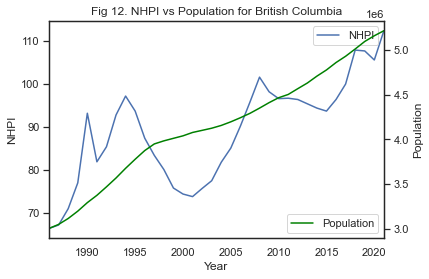

In [98]:
#Query for the NHPI and Population of British Columbia
temp1 = province_df['British Columbia']
temp2 = province_df_Pop['British Columbia']
NHPIvsPop_BC = temp1[~temp1.VALUE.isna()].merge(temp2[~temp2.VALUE.isna()],on='REF_DATE',suffixes=('_NHPI','_Pop'))\
    .drop(columns=['GEO_NHPI','GEO_Pop','New housing price indexes'])

#Plot a 2 y-axes line plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
NHPIvsPop_BC.plot(x='REF_DATE',y='VALUE_NHPI',ax=ax1)
ax1.set_ylabel('NHPI')
ax1.set_xlabel('Year')
ax1.legend(['NHPI'], loc = 0)
NHPIvsPop_BC.plot(x='REF_DATE',y='VALUE_Pop',color="green",ax=ax2)
ax2.set_ylabel('Population')
ax2.legend(['Population'],loc = 4)
ax1.set_title('Fig 12. NHPI vs Population for British Columbia')
plt.show()

4. Alberta

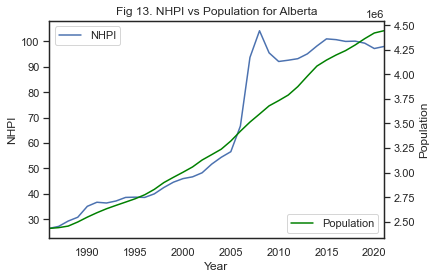

In [99]:
#Query for the NHPI and Population of Alberta
temp1 = province_df['Alberta']
temp2 = province_df_Pop['Alberta']
NHPIvsPop_AB = temp1[~temp1.VALUE.isna()].merge(temp2[~temp2.VALUE.isna()],on='REF_DATE',suffixes=('_NHPI','_Pop'))\
    .drop(columns=['GEO_NHPI','GEO_Pop','New housing price indexes'])

#Plot a 2 y-axes line plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
NHPIvsPop_AB.plot(x='REF_DATE',y='VALUE_NHPI',ax=ax1)
ax1.set_ylabel('NHPI')
ax1.set_xlabel('Year')
ax1.legend(['NHPI'])
NHPIvsPop_AB.plot(x='REF_DATE',y='VALUE_Pop',color="green",ax=ax2)
ax2.set_ylabel('Population')
ax2.legend(['Population'],loc = 4)
ax1.set_title('Fig 13. NHPI vs Population for Alberta')
plt.show()

5. Saskatchewan

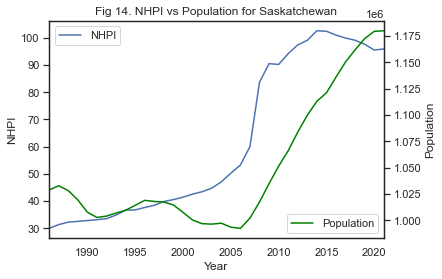

In [100]:
#Query for the NHPI and Population of Saskatchewan
temp1 = province_df['Saskatchewan']
temp2 = province_df_Pop['Saskatchewan']
NHPIvsPop_SK = temp1[~temp1.VALUE.isna()].merge(temp2[~temp2.VALUE.isna()],on='REF_DATE',suffixes=('_NHPI','_Pop'))\
    .drop(columns=['GEO_NHPI','GEO_Pop','New housing price indexes'])

#Plot a 2 y-axes line plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
NHPIvsPop_SK.plot(x='REF_DATE',y='VALUE_NHPI',ax=ax1)
ax1.set_ylabel('NHPI')
ax1.set_xlabel('Year')
ax1.legend(['NHPI'])
NHPIvsPop_SK.plot(x='REF_DATE',y='VALUE_Pop',color="green",ax=ax2)
ax2.set_ylabel('Population')
ax2.legend(['Population'],loc = 4)
ax1.set_title('Fig 14. NHPI vs Population for Saskatchewan')
plt.show()

### Supply side analysis
According to the Bank of Canada report on pg. 10, geography and regulation are the factors that most constraint the supply of housing. However, this work will yet touch on these factors since the data is not readily available. Instead, we will employ industrial product price index, which contains price index of construction materials such as lumber and metal product to observe its relation ship with NHPI. More specifically, this work computes the average price index of lumber product, fabricated metal product and construction materials), and chemical products. It is noted that the available industrial price data is aggregated for Canada and does not provide details for each province.

#### NHPI vs IPPI
**Findings**
- Over a long period of time, it can be seen that NHPI does not correlate with industrial product price index as shown in Fig 15. Specifically, during 2000-2018, it is clear that NHPI increases at a faster rate than IPPI. Moreover, NHPI can even drop for Vancouver while IPPI increases slightly during the same period. All of this indicates IPPI generally only play a minor role in NHPI.

- However, when there is a sudden spike in IPPI as shown in Fig 16, where IPPI increases by 150%, only during 8 months, between July 2020 and March 2021. We can see NHPI correlates immediately with IPPI of construction materical. 

- Interestingly, if we look at Quebec case, we can see in the figure that its NHPI increased before there were a change in IPPI of construction product. Thus, there remains an interesting case to look into to find the possible elements that could explain this behavior of NHPI of Quebec. 

##### Canada and the top 3 economically biggest provinces

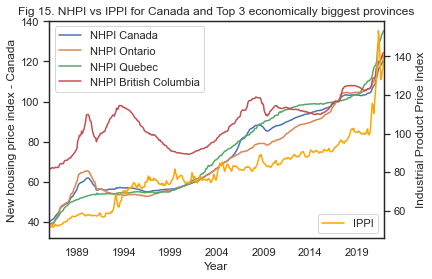

In [101]:
#Perform a query on 2 tables: NHPI and income
NHPIvsIPPI = df[df.GEO =='Canada'].merge(dfIndu,on='REF_DATE',suffixes=("_NHPI_CAN","_IPPI"))\
    .drop(columns=['GEO','New housing price indexes'])
on = province_df['Ontario'][['REF_DATE','VALUE']].rename(columns={"VALUE":"VALUE_NHPI_ON"})
on = on[~on.VALUE_NHPI_ON.isna()]
qc = province_df['Quebec'][['REF_DATE','VALUE']].rename(columns={"VALUE":"VALUE_NHPI_QC"})
qc = qc[~qc.VALUE_NHPI_QC.isna()]
bc = province_df['British Columbia'][['REF_DATE','VALUE']].rename(columns={"VALUE":"VALUE_NHPI_BC"})
bc = bc[~bc.VALUE_NHPI_BC.isna()]
NHPIvsIPPI = NHPIvsIPPI.merge(on,on='REF_DATE').merge(qc,on='REF_DATE').merge(bc,on="REF_DATE")
#Plot a 2 y-axes line plot
sns.set_theme(style="white", palette=None)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
NHPIvsIPPI.plot(x='REF_DATE',y=['VALUE_NHPI_CAN','VALUE_NHPI_ON','VALUE_NHPI_QC','VALUE_NHPI_BC'],ax=ax1)
ax1.set_ylabel('New housing price index - Canada')
ax1.set_xlabel('Year')
ax1.legend(['NHPI Canada','NHPI Ontario','NHPI Quebec','NHPI British Columbia'])
NHPIvsIPPI.plot(x='REF_DATE',y='VALUE_IPPI',color="orange",ax=ax2)
ax2.set_ylabel('Industrial Product Price Index')
ax2.legend(['IPPI'],loc=4)
ax1.set_title('Fig 15. NHPI vs IPPI for Canada and Top 3 economically biggest provinces')
plt.show()

It can be clearly seen in the graph above that approximately after 2019, there was a drastic spike in IPPI of the 3 specified product type. This period could be of interest since it could show that the main factor for increase in NHPI during this period is mainly due to the change in IPPI. Especially when the other factors such as income and population is shown in the sections above to not change as rapidly during this period.

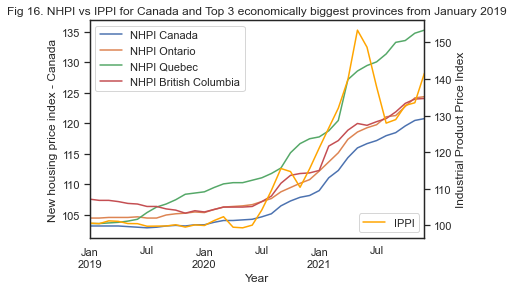

In [102]:
NHPIvsIPPI = NHPIvsIPPI[NHPIvsIPPI.REF_DATE>='01-01-2019']
#Plot a 2 y-axes line plot
sns.set_theme(style="white", palette=None)
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
NHPIvsIPPI.plot(x='REF_DATE',y=['VALUE_NHPI_CAN','VALUE_NHPI_ON','VALUE_NHPI_QC','VALUE_NHPI_BC'],ax=ax1)
ax1.set_ylabel('New housing price index - Canada')
ax1.set_xlabel('Year')
ax1.legend(['NHPI Canada','NHPI Ontario','NHPI Quebec','NHPI British Columbia'])
NHPIvsIPPI.plot(x='REF_DATE',y='VALUE_IPPI',color="orange",ax=ax2)
ax2.set_ylabel('Industrial Product Price Index')
ax2.legend(['IPPI'],loc=4)
ax1.set_title('Fig 16. NHPI vs IPPI for Canada and Top 3 economically biggest provinces from January 2019')
plt.show()

Evidently, this period alligns with the COVID-19 pandemic where there are a lot of quantitative easing policy from the government. Thus, we need to take into consideration of this in future work as well.